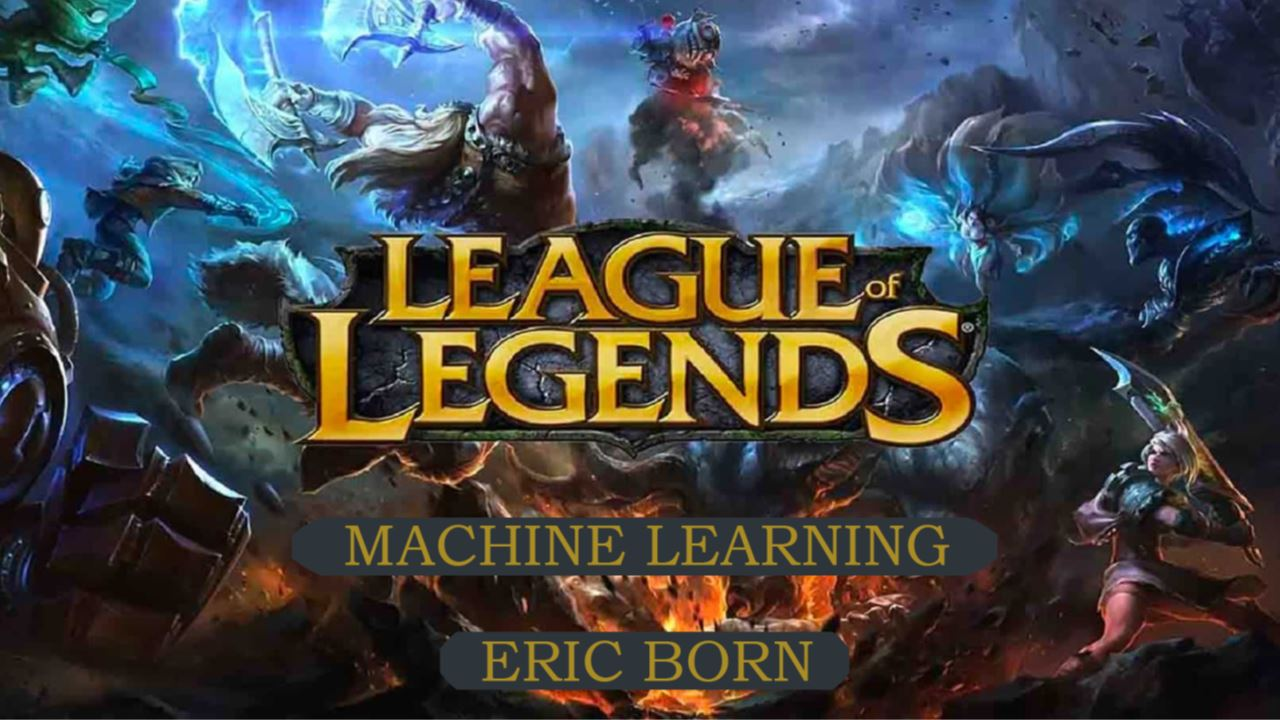

## League of Legends

LoL for short, is a multiplayer online battle arena video game where two teams of five players each battle to destroy the opposite teams base. 

For this project I chose to use machine learning to predict which team will win the match.

In [1]:
# Import libraries
import os
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sys import exit
from sklearn import svm
from sklearn import tree
from sklearn.feature_selection import RFE
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix, recall_score

# ignore warnings due to converstion messages, etc.
warnings.filterwarnings('ignore')

# set seaborn to dark backgrounds
sns.set_style("darkgrid")

### Dataset Features
At a quick glance the dataset contains 61 features each representing a different aspect of how one of the two teams performed and 51491 rows, each row representing a single match between two teams. The features are outlined below:

Game ID, Creation Time (in Epoch format), Game Duration (in seconds), Season ID, 
Winner (1 = team1, 2 = team2), 
First Baron, dragon, tower, blood, inhibitor and Rift Herald (1 = team1, 2 = team2), 
Champions and summoner spells for each team (Stored as Riot's champion and summoner spell IDs), The number of tower, inhibitor, Baron, dragon and Rift Herald kills each team has, 
The 5 bans of each team (Again, champion IDs are used)

The original dataset can be found here:
https://www.kaggle.com/datasnaek/league-of-legends/downloads/league-of-legends.zip/9

### Data Cleanup:
Before starting any work on the ML algorithms, I examined and cleaned the data. I chose to remove the gameID, creationTime and seasonId columns as the entire dataset consisted of only data from season 9 and the gameID and creationTime are irrelevant to the study I will be performing. 

I also decided to rename the winner column to win and changed the values from 1 and 2 to 0 and 1 respectively.

This leaves 57 features plus the win column, which will be used for testing the models accuracy.

In [2]:
# setup input directory and filename
data = 'LoL'
input_dir = r'C:\Users\TomBrody\Desktop\School\677\Final'
csv_file = os.path.join(input_dir, data + '.csv')

# read csv file into dataframe
try:
    lol_df = pd.read_csv(csv_file)
    print('opened file for ticker: ', data, '\n')

except Exception as e:
    print(e)
    exit('Failed to read LoL data from: '+ str(data)+'.csv')

# describe the total rows and columns
print('The total length of the dataframe is', lol_df.shape[0], 'rows',
      'and the width is', lol_df.shape[1], 'columns')

# create a class label using 0 or 1 to indicate winning team
# 0 = team 1 won
# 1 = team 2 won
lol_df['win'] = lol_df['winner'].apply(lambda x: 0 if x == 1 else 1)

# remove columns gameId, creationTime, seasonId and winner
lol_df.drop(lol_df.columns[[0,1,3,4]], axis = 1, inplace = True)

# 58 columns remaining
print(lol_df.head())

# x stores all columns except for the win column
lol_x = lol_df.drop('win', 1)

# y stores only the win column since its used as a predictor
lol_y = lol_df['win']

opened file for ticker:  LoL 

The total length of the dataframe is 51490 rows and the width is 61 columns
   gameDuration  firstBlood  firstTower  firstInhibitor  firstBaron  \
0          1949           2           1               1           1   
1          1851           1           1               1           0   
2          1493           2           1               1           1   
3          1758           1           1               1           1   
4          2094           2           1               1           1   

   firstDragon  firstRiftHerald  t1_champ1id  t1_champ1_sum1  t1_champ1_sum2  \
0            1                2            8              12               4   
1            1                1          119               7               4   
2            2                0           18               4               7   
3            1                0           57               4              12   
4            1                0           19               4      

### Feature Selection:
Since there are so many columns in the dataset I decided to do some feature selection before building or training any machine learning models to boost their speed and hopefully their accuracy. 

I chose to use four methods for feature selection, Pearson’s correlation coefficient, ordinary least squares, recursive feature elimination and Lasso (least absolute shrinkage and selection operator).

#### Pearson's
For Pearson’s I calculated the correlation between each of the features to the win column and then set a threshold of at least 0.5 correlation, this resulted in five features. I performed the same test with a threshold of 0.35 which resulted in ten features. Both of these were used to create their own dataframes containing only the columns selected by the correlation tests.

In [3]:
# create a correlation object
cor = lol_df.corr()

# correlation with output variable
cor_target = abs(cor['win'])

# selecting features correlated greater than 0.5
relevant_features_five = cor_target[cor_target>0.5]

# second set of features correlated greater than 0.35
relevant_features_ten = cor_target[cor_target > 0.35]

# create dataframe top 5 correlated features
pear_five_df = lol_df[['firstInhibitor', 't1_towerKills', 't1_inhibitorKills', 
                      't2_towerKills', 't2_inhibitorKills']]


# create dataframe top 10 correlated features
pear_ten_df = lol_df[['firstTower','firstInhibitor', 't1_towerKills',
                       't1_inhibitorKills', 't1_baronKills', 't1_dragonKills',
                       't2_towerKills', 't2_inhibitorKills', 't2_baronKills',
                       't2_dragonKills']]

# results for the top 5 and top 10 features
print('Pearsons top 5 features:')
print(list(pear_five_df.columns), '\n')

print('Pearsons top 10 features:')
print(list(pear_ten_df.columns), '\n')

Pearsons top 5 features:
['firstInhibitor', 't1_towerKills', 't1_inhibitorKills', 't2_towerKills', 't2_inhibitorKills'] 

Pearsons top 10 features:
['firstTower', 'firstInhibitor', 't1_towerKills', 't1_inhibitorKills', 't1_baronKills', 't1_dragonKills', 't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills'] 



#### Ordinary Least Squares
To create the third feature set I used the ordinary least squares function from the statsmodel library by fitting the column data with the win column and creating a linear regression model. The p-value of the features were then evaluated and if they were greater than 0.05 they were eliminated. 

This process left me with 22 features.

In [4]:
# creates a list of column names
cols = list(lol_x.columns)
# sets a max value
pmax = 1

# while loop that calculates the p values of each feature using the 
# OLS model and eliminiates the highest value from the list of columns
# loop breaks if all columns remaining have less than 0.05 p value
# or all columns are removed
try:
    while (len(cols)>0):
        p = []
        ols_x1 = sm.add_constant(lol_x[cols].values)
        model = sm.OLS(lol_y,ols_x1).fit()
        p = pd.Series(model.pvalues.values[1:], index = cols)
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        if(pmax > 0.05):
            cols.remove(feature_with_p_max)
        else:
            break
except Exception as e:
    print(e)
    exit('Failed to reduce features for ols dataset')
    
# sets and prints the remaining unremoved features
selected_features_BE = cols

# creates a dataframe with the ols selected columns
ols_df = lol_df[selected_features_BE]

print('Total features:', len(selected_features_BE),
    '\nOrdinary Least Squares features:\n', selected_features_BE)

Total features: 22 
Ordinary Least Squares features:
 ['firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron', 'firstRiftHerald', 't1_champ3id', 't1_champ3_sum1', 't1_champ5id', 't1_champ5_sum1', 't1_towerKills', 't1_inhibitorKills', 't1_baronKills', 't1_dragonKills', 't1_riftHeraldKills', 't2_champ1id', 't2_champ2id', 't2_champ3id', 't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills', 't2_riftHeraldKills']


#### Recursive Feature Elimination
I utilized the feature selection library from sklearn to perform RFE, or recursive feature selection. This library works to recursively consider smaller and smaller sets of features by measuring the features coefficient and pruning the least important features. 

This method resulted in 39 features. Since the actual loop process is pretty slow to compute, the below code block can be skipped and 39 can be plugged straight into the RFE in the following block. 

In [ ]:
#!!! Can be skipped due to slow performance!!!

# Total number of features
nof_list = np.arange(1,58)            
high_score = 0

# Variable to store the optimum features
nof = 0           
score_list = []
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(lol_x, lol_y, 
                                            test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score > high_score):
        high_score = score
        nof = nof_list[n]

# 39 features score of 0.793475
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

#!!! Can be skipped due to slow performance!!!

In [5]:
# setup column list and regression model
cols = list(lol_x.columns)
model = LinearRegression()

#Initializing RFE model with 39 features
rfe = RFE(model, 39)   
          
#Transforming data using RFE
X_rfe = rfe.fit_transform(lol_x,lol_y)  

#Fitting the data to model
model.fit(X_rfe,lol_y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index

# creates a dataframe with the rfe selected columns
rfe_df = lol_df[selected_features_rfe]

# output the selected features
print('Total features:', len(selected_features_rfe),
    '\nRecursive Feature Elimination features:\n', selected_features_rfe)

Total features: 39 
Recursive Feature Elimination features:
 Index(['firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron',
       'firstDragon', 'firstRiftHerald', 't1_champ1_sum1', 't1_champ1_sum2',
       't1_champ2_sum1', 't1_champ2_sum2', 't1_champ3id', 't1_champ3_sum1',
       't1_champ3_sum2', 't1_champ4_sum1', 't1_champ4_sum2', 't1_champ5id',
       't1_champ5_sum1', 't1_champ5_sum2', 't1_towerKills',
       't1_inhibitorKills', 't1_baronKills', 't1_dragonKills',
       't1_riftHeraldKills', 't2_champ1_sum1', 't2_champ1_sum2', 't2_champ2id',
       't2_champ2_sum1', 't2_champ2_sum2', 't2_champ3_sum1', 't2_champ3_sum2',
       't2_champ4_sum1', 't2_champ4_sum2', 't2_champ5_sum1', 't2_champ5_sum2',
       't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills',
       't2_riftHeraldKills'],
      dtype='object')


#### Lasso
The final feature selection method used was lasso cv, least absolute shrinkage and selection operator with cross validation. This was also implemented from the SKlearn library. 

The method resulted in 32 features selected.

In [6]:
# build the model with a cross validation set to 5
reg = LassoCV(cv = 5)

# fit the model
reg.fit(lol_x, lol_y)

# build the coefficients between each attribute
coef = pd.Series(reg.coef_, index = lol_x.columns)

# creates a dataframe based on the 32 columns selected from lasso
lasso_df = lol_df[coef[coef.values != 0].index]

# output total attributes chosen and discarded
print("Total Features: " + str(sum(coef != 0)),
      '\nLasso features:\n',list(lasso_df.columns))

Total Features: 32 
Lasso features:
 ['gameDuration', 'firstTower', 'firstRiftHerald', 't1_champ1id', 't1_champ2id', 't1_champ3id', 't1_champ3_sum1', 't1_champ4id', 't1_champ5id', 't1_champ5_sum1', 't1_towerKills', 't1_baronKills', 't1_dragonKills', 't1_ban1', 't1_ban2', 't1_ban3', 't1_ban4', 't2_champ1id', 't2_champ1_sum1', 't2_champ2id', 't2_champ2_sum2', 't2_champ3id', 't2_champ3_sum2', 't2_champ4id', 't2_champ5id', 't2_towerKills', 't2_baronKills', 't2_ban1', 't2_ban2', 't2_ban3', 't2_ban4', 't2_ban5']


#### Scaled and Non-Scaled Datasets:
After establishing the features identified by the five methods, I needed to create both scaled and non-scaled versions of the dataframes for use with the various algorithms. 

The scaled versions were created with the standard scaler from the sklearn preprocessing library. This library transforms the dataframe into an array and then scales the data to center by removing the mean value of each feature, then dividing non-constant features by their standard deviation. 

This step is also needed for any algorithm that operates based upon distance, such as KNN, as large variations in values translate to large distances between neighbors and make it difficult for the algorithms to learn from and predict on.

Both datasets were split into training and test sets using 66.6% for the training and 33.3 for testing and utilized a random state of 1337 to ensure repeatability in all of the testing results.

In [7]:
# Start building scaled test/train datasets

# Setup scalers for pear_five_df
scaler = StandardScaler()
scaler.fit(pear_five_df)
pear_five_df_scaled = scaler.transform(pear_five_df)

# pear_five split dataset into 33% test 66% training
(pear_five_scaled_df_train_x, pear_five_scaled_df_test_x, 
 pear_five_scaled_df_train_y, pear_five_scaled_df_test_y) = (
        train_test_split(pear_five_df_scaled, lol_y, test_size = 0.333, 
                         random_state=1337))

# Setup scalers for pear_ten_df
scaler = StandardScaler()
scaler.fit(pear_ten_df)
pear_ten_df_scaled = scaler.transform(pear_ten_df)

# pear_ten split dataset into 33% test 66% training
(pear_ten_scaled_df_train_x, pear_ten_scaled_df_test_x,
 pear_ten_scaled_df_train_y, pear_ten_scaled_df_test_y) = (
        train_test_split(pear_ten_df_scaled, lol_y, test_size = 0.333, 
                         random_state=1337))

# Setup scalers for OLS
scaler = StandardScaler()
scaler.fit(ols_df)
ols_df_scaled = scaler.transform(ols_df)

# ols_df split dataset into 33% test 66% training
(ols_scaled_df_train_x, ols_scaled_df_test_x, ols_scaled_df_train_y,
 ols_scaled_df_test_y) = (
        train_test_split(ols_df_scaled, lol_y, test_size = 0.333, 
                         random_state=1337))

# Setup scalers for RFE
scaler = StandardScaler()
scaler.fit(rfe_df)
rfe_df_scaled = scaler.transform(rfe_df)

# ols_df split dataset into 33% test 66% training
(rfe_scaled_df_train_x, rfe_scaled_df_test_x, 
 rfe_scaled_df_train_y, rfe_scaled_df_test_y) = (
        train_test_split(rfe_df_scaled, lol_y, test_size = 0.333, 
                         random_state=1337))

# Setup scalers for Lasso
scaler = StandardScaler()
scaler.fit(lasso_df)
lasso_df_scaled = scaler.transform(lasso_df)

# lasso split dataset into 33% test 66% training
(lasso_scaled_df_train_x, lasso_scaled_df_test_x, lasso_scaled_df_train_y, 
lasso_scaled_df_test_y) = (train_test_split(lasso_df_scaled, lol_y, 
                                             test_size = 0.333, 
                                             random_state=1337))

# End building scaled dataframes

# Start building non-scaled test/train datasets

# pear_five split dataset into 33% test 66% training
(pear_five_df_train_x, pear_five_df_test_x, 
pear_five_df_train_y, pear_five_df_test_y) = (
        train_test_split(pear_five_df, lol_y, test_size = 0.333, 
                         random_state=1337))

# pear_ten split dataset into 33% test 66% training
(pear_ten_df_train_x, pear_ten_df_test_x, 
 pear_ten_df_train_y, pear_ten_df_test_y) = (
        train_test_split(pear_ten_df, lol_y, test_size = 0.333, 
                         random_state=1337))

# ols_df split dataset into 33% test 66% training
ols_df_train_x, ols_df_test_x, ols_df_train_y, ols_df_test_y = (
        train_test_split(ols_df, lol_y, test_size = 0.333, 
                         random_state=1337))

# ols_df split dataset into 33% test 66% training
rfe_df_train_x, rfe_df_test_x, rfe_df_train_y, rfe_df_test_y = (
        train_test_split(rfe_df, lol_y, test_size = 0.333, 
                         random_state=1337))

# ols_df split dataset into 33% test 66% training
lasso_df_train_x, lasso_df_test_x, lasso_df_train_y, lasso_df_test_y = (
        train_test_split(lasso_df, lol_y, test_size = 0.333, 
                         random_state=1337))

# ols_df split dataset into 33% test 66% training
full_df_train_x, full_df_test_x, full_df_train_y, full_df_test_y = (
        train_test_split(lol_x, lol_y, test_size = 0.333, 
                         random_state=1337))

#### Algorithms:
Finally, after all of the prep and setup, it’s time to train and test some algorithms! 

I chose to implement six different algorithms, three using scaled data sets and three using non-scaled. 
For the scaled group I implemented KNN, SVM and Logistic Regression and the non-scaled on Decision tree, Naïve Bayes and Random Forest. 

With SVM I wanted to compare using three different kernels, linear, Gaussian and polynomial and logistic regression using three solvers, liblinear, sag and newton-cg to see if there was any difference in speed or accuracy. 

With KNN I tested K at a value between 3 to 25 in increments of 2 and random forest with a range of 1 to 26 estimators and 1 to 10 depth. 

Each of these was tested on the five datasets previous created with an additional test for Random Forest on a fully featured dataset, just to see how it would perform. This brought the total implementations to 51.

In [13]:
%%html
<!––Used to move the table to the left -->
<style>
  table {margin-left: 0 !important;}
</style>

#### Decision Tree

For the Decision Tree implementation I choose to use entropy as the measurement for splitting.

In [25]:
# setup empty list to store all of the models accuracy
global_accuracy = []

# Create list just for the algorithm durations
algorithm_duration_list = []

# start time
algorithm_duration_list.append(time.time()) 

# Create a decisions tree classifier
pear_five_tree_clf = tree.DecisionTreeClassifier(criterion = 'entropy')

# Train the classifier on pearsons top 5 attributes
pear_five_tree_clf = pear_five_tree_clf.fit(pear_five_df_train_x, 
                                            pear_five_df_train_y)

# Predict on pearsons top 5 attributes
pear_five_prediction = pear_five_tree_clf.predict(pear_five_df_test_x)

####
# End five
####

####
# Start ten
####

# Create a decisions tree classifier
pear_ten_tree_clf = tree.DecisionTreeClassifier(criterion = 'entropy')

# Train the classifier on pearsons top 10 attributes
pear_ten_tree_clf = pear_ten_tree_clf.fit(pear_ten_df_train_x, 
                                            pear_ten_df_train_y)

# Predict on pearsons top 10 attributes
pear_ten_prediction = pear_ten_tree_clf.predict(pear_ten_df_test_x)

####
# End ten
####

####
# Start ols_df
####

# Create a decisions tree classifier
ols_df_tree_clf = tree.DecisionTreeClassifier(criterion = 'entropy')

# Train the classifier on ols attributes
ols_df_tree_clf = ols_df_tree_clf.fit(ols_df_train_x, 
                                            ols_df_train_y)

# Predict on ols attributes
ols_df_prediction = ols_df_tree_clf.predict(ols_df_test_x)

####
# End ols_df
####

####
# Start rfe_df
####

# Create a decisions tree classifier
rfe_df_tree_clf = tree.DecisionTreeClassifier(criterion = 'entropy')

# Train the classifier on rfe attributes
rfe_df_tree_clf = rfe_df_tree_clf.fit(rfe_df_train_x, 
                                            rfe_df_train_y)

# Predict on rfe attributes
rfe_df_prediction = rfe_df_tree_clf.predict(rfe_df_test_x)

####
# End rfe_df
####

####
# Start lasso_df
####

# Create a decisions tree classifier
lasso_df_tree_clf = tree.DecisionTreeClassifier(criterion = 'entropy')

# Train the classifier on lasso attributes
lasso_df_tree_clf = lasso_df_tree_clf.fit(lasso_df_train_x, 
                                            lasso_df_train_y)

# Predict on lasso attributes
lasso_df_prediction = lasso_df_tree_clf.predict(lasso_df_test_x)

# end time
algorithm_duration_list.append(time.time()) 

####
# End lasso_df
####

# Store predictions
global_accuracy.append(100-(round(np.mean(pear_five_prediction 
                                          != pear_five_df_test_y) * 100, 2)))
global_accuracy.append(100-(round(np.mean(pear_ten_prediction 
                                          != pear_ten_df_test_y) * 100, 2)))
global_accuracy.append(100-(round(np.mean(ols_df_prediction 
                                          != ols_df_test_y) * 100, 2)))
global_accuracy.append(100-(round(np.mean(rfe_df_prediction 
                                          != rfe_df_test_y) * 100, 2)))
global_accuracy.append(100-(round(np.mean(lasso_df_prediction 
                                          != lasso_df_test_y) * 100, 2)))

print('Decision Tree accuracy:',
      '\npearsons five:',global_accuracy[0],
      '\npearsons ten:',global_accuracy[1],
      '\nOLS:',global_accuracy[2],
      '\nRFE:',global_accuracy[3],
      '\nLasso:',global_accuracy[4])

Decision Tree accuracy: 
pearsons five: 96.67 
pearsons ten: 96.15 
OLS: 95.85 
RFE: 95.83 
Lasso: 94.72


We can see from the accuracy measurements that the model performed the best with the least number of features, Pearson's five at ~96.67%, and the worst on the Lasso set at ~94.76%

#### Naive Bayes

The next algorithm is the Gaussian implementation of Naive Bayes.

In [24]:
####
# Start five
####

# Create a naive bayes classifier
pear_five_gnb_clf = GaussianNB()

# Train the classifier on pearsons top 5 attributes
pear_five_gnb_clf = pear_five_gnb_clf.fit(pear_five_df_train_x, 
                                          pear_five_df_train_y)

# Predict on pearsons top 5 attributes
pear_five_prediction = pear_five_gnb_clf.predict(pear_five_df_test_x)

####
# End five
####

####
# Start ten
####

# Create a naive bayes classifier
pear_ten_gnb_clf = GaussianNB()

# Train the classifier on pearsons top 10 attributes
pear_ten_gnb_clf = pear_ten_gnb_clf.fit(pear_ten_df_train_x, 
                                        pear_ten_df_train_y)

# Predict on pearsons top 10 attributes
pear_ten_prediction = pear_ten_gnb_clf.predict(pear_ten_df_test_x)

####
# End ten
####

####
# Start ols_df
####

# start timing
algorithm_duration_list.append(time.time())

# Create a naive bayes classifier
ols_df_gnb_clf = GaussianNB()

# Train the classifier on ols attributes
ols_df_gnb_clf = ols_df_gnb_clf.fit(ols_df_train_x, 
                                    ols_df_train_y)

# Predict on ols attributes
ols_df_prediction = ols_df_gnb_clf.predict(ols_df_test_x)

####
# End ols_df
####

####
# Start rfe_df
####

# Create a naive bayes classifier
rfe_df_gnb_clf = GaussianNB()

# Train the classifier on rfe attributes
rfe_df_gnb_clf = rfe_df_gnb_clf.fit(rfe_df_train_x, 
                                    rfe_df_train_y)

# Predict on rfe attributes
rfe_df_prediction = rfe_df_gnb_clf.predict(rfe_df_test_x)

####
# End rfe_df
####

####
# Start lasso_df
####

# Create a naive bayes classifier
lasso_df_gnb_clf = GaussianNB()

# Train the classifier on lasso attributes
lasso_df_gnb_clf = lasso_df_gnb_clf.fit(lasso_df_train_x, 
                                        lasso_df_train_y)

# Predict on lasso attributes
lasso_df_prediction = lasso_df_gnb_clf.predict(lasso_df_test_x)

####
# End lasso_df
####

# Store predictions
global_accuracy.append(100-(round(np.mean(pear_five_prediction 
                                          != pear_five_df_test_y) * 100, 2)))
global_accuracy.append(100-(round(np.mean(pear_ten_prediction 
                                          != pear_ten_df_test_y) * 100, 2)))
global_accuracy.append(100-(round(np.mean(ols_df_prediction 
                                          != ols_df_test_y) * 100, 2)))
global_accuracy.append(100-(round(np.mean(rfe_df_prediction 
                                          != rfe_df_test_y) * 100, 2)))
global_accuracy.append(100-(round(np.mean(lasso_df_prediction 
                                          != lasso_df_test_y) * 100, 2)))

print('Naive Bayes accuracy:',
      '\npearsons five:',global_accuracy[5],
      '\npearsons ten:',global_accuracy[6],
      '\nOLS:',global_accuracy[7],
      '\nRFE:',global_accuracy[8],
      '\nLasso:',global_accuracy[9])

Naive Bayes accuracy: 
pearsons five: 93.91 
pearsons ten: 94.36 
OLS: 94.02 
RFE: 93.79 
Lasso: 94.48


Naive Bayes performed the opposite of Random Forest, Lasso being the most accurate and Pearson's Five being the least, but was still 2% less accurate than Random Forest.

#### Random Forest
With Random Forest I wanted to test varrying levels of estimators and depth to find optimal settings. The following code is quite slow due to each feature set being testing with a range of 1-25 estimators and a depth of 1-10, thats a total of 250 tests per set for a total of 1500 tests!

In [ ]:
####
# Start RF accuracy tests
####

# Random forest classifiers using a range from
# 1 to 25 trees and from 1 to 10 depth of each tree
# Set random state to 1337 for repeatability

# Create a list to store the optimal tree and depth values 
# for each random forest classifier
trees_depth = []

rf_accuracy_df = pd.DataFrame()

####
# Start pear five dataSet
####

pred_list = []

# RF with iterator
for trees in range(1, 26):
    for depth in range(1, 11):
        rf_clf = RandomForestClassifier(n_estimators = trees, 
                                    max_depth = depth, criterion ='entropy',
                                    random_state = 1337)
        rf_clf.fit(pear_five_df_train_x, pear_five_df_train_y)
        pred_list.append([trees, depth, 
                    round(np.mean(rf_clf.predict(pear_five_df_test_x) 
                    == pear_five_df_test_y) 
                    * 100, 2), 'pear_five'])
         
#create a dataframe from the classifer data
forest_df_1 = pd.DataFrame(pred_list, columns = ['Estimators', 'Depth',
                                                 'Accuracy', 'Set'])

# append forest 1 to full df
rf_accuracy_df = rf_accuracy_df.append(forest_df_1)

# store the lowest error rate value from the classifier
ind = forest_df_1.loc[forest_df_1['Accuracy'] == 
                      max(forest_df_1.Accuracy)].values

# pull out the number of trees and depth
trees_depth.append(int(ind.item(0)))
trees_depth.append(int(ind.item(1)))

# append the models accruacy to the accuracy list
global_accuracy.append(round(ind.item(2), 2))

print('Pearsons Five:\nOptimal trees:', trees_depth[0],
      '\nOptimal depth:', trees_depth[1])

####
# End pear five dataSet
####

####
# Start pear ten dataSet
####

pred_list = []

for trees in range(1, 26):
    for depth in range(1, 11):
        rf_clf = RandomForestClassifier(n_estimators = trees, 
                                    max_depth = depth, criterion ='entropy',
                                    random_state = 1337)
        rf_clf.fit(pear_ten_df_train_x, pear_ten_df_train_y)
        pred_list.append([trees, depth, 
                    round(np.mean(rf_clf.predict(pear_ten_df_test_x) 
                    == pear_ten_df_test_y) 
                    * 100, 2), 'pear_ten'])

# create a dataframe from the classifer data
forest_df_2 = pd.DataFrame(pred_list, columns = ['Estimators', 'Depth',
                                                 'Accuracy', 'Set'])

# append forest 2 to full df
rf_accuracy_df = rf_accuracy_df.append(forest_df_2)

# store the lowest error rate value from the classifier
ind = forest_df_2.loc[forest_df_2['Accuracy'] == 
                      max(forest_df_2.Accuracy)].values

# pull out the number of trees and depth
trees_depth.append(int(ind.item(0)))
trees_depth.append(int(ind.item(1)))

# append the models accruacy to the accuracy list
global_accuracy.append(round(ind.item(2), 2))

print('Pearsons Ten:\nOptimal trees:', trees_depth[2],
      '\nOptimal depth:', trees_depth[3])

####
# End pear ten dataSet
####

####
# Start ols dataSet
####

pred_list = []

for trees in range(1, 26):
    for depth in range(1, 11):
        rf_clf = RandomForestClassifier(n_estimators = trees, 
                                    max_depth = depth, criterion ='entropy',
                                    random_state = 1337)
        rf_clf.fit(ols_df_train_x, ols_df_train_y)
        pred_list.append([trees, depth, 
                    round(np.mean(rf_clf.predict(ols_df_test_x) 
                    == ols_df_test_y) 
                    * 100, 2), 'ols'])

# create a dataframe from the classifer data
forest_df_3 = pd.DataFrame(pred_list, columns = ['Estimators', 'Depth',
                                                 'Accuracy', 'Set'])

# append forest 3 to full df
rf_accuracy_df = rf_accuracy_df.append(forest_df_3)

# store the lowest error rate value from the classifier
ind = forest_df_3.loc[forest_df_3['Accuracy'] == 
                      max(forest_df_3.Accuracy)].values
                      
# pull out the number of trees and depth
trees_depth.append(int(ind.item(0)))
trees_depth.append(int(ind.item(1)))

# append the models accruacy to the accuracy list
global_accuracy.append(round(ind.item(2), 2))

print('OLS:\nOptimal trees:', trees_depth[4],
      '\nOptimal depth:', trees_depth[5])


####
# End ols dataSet
####

####
# Start rfe dataSet
####

pred_list = []

for trees in range(1, 26):
    for depth in range(1, 11):
        rf_clf = RandomForestClassifier(n_estimators = trees, 
                                    max_depth = depth, criterion ='entropy',
                                    random_state = 1337)
        rf_clf.fit(rfe_df_train_x, rfe_df_train_y)
        pred_list.append([trees, depth, 
                    round(np.mean(rf_clf.predict(rfe_df_test_x) 
                    == rfe_df_test_y) 
                    * 100, 2), 'rfe'])

# create a dataframe from the classifer data
forest_df_4 = pd.DataFrame(pred_list, columns = ['Estimators', 'Depth',
                                                 'Accuracy', 'Set'])

# append forest 4 to full df
rf_accuracy_df = rf_accuracy_df.append(forest_df_4)

# store the lowest error rate value from the classifier
ind = forest_df_4.loc[forest_df_4['Accuracy'] == 
                      max(forest_df_4.Accuracy)].values
                      
# pull out the number of trees and depth
trees_depth.append(int(ind.item(0)))
trees_depth.append(int(ind.item(1)))

# append the models accruacy to the accuracy list
global_accuracy.append(round(ind.item(2), 2))

print('RFE:\nOptimal trees:', trees_depth[6],
      '\nOptimal depth:', trees_depth[7])

####
# End rfe dataSet
####

####
# Start lasso dataSet
####

pred_list = []

for trees in range(1, 26):
    for depth in range(1, 11):
        rf_clf = RandomForestClassifier(n_estimators = trees, 
                                    max_depth = depth, criterion ='entropy',
                                    random_state = 1337)
        rf_clf.fit(lasso_df_train_x, lasso_df_train_y)
        pred_list.append([trees, depth, 
                    round(np.mean(rf_clf.predict(lasso_df_test_x) 
                    == lasso_df_test_y) 
                    * 100, 2), 'lasso'])

# create a dataframe from the classifer data
forest_df_5 = pd.DataFrame(pred_list, columns = ['Estimators', 'Depth',
                                                 'Accuracy', 'Set'])

# append forest 5 to full df
rf_accuracy_df = rf_accuracy_df.append(forest_df_5)

# store the lowest error rate value from the classifier
ind = forest_df_5.loc[forest_df_5['Accuracy'] == 
                      max(forest_df_5.Accuracy)].values
                      
# pull out the number of trees and depth
trees_depth.append(int(ind.item(0)))
trees_depth.append(int(ind.item(1)))

# append the models accruacy to the accuracy list
global_accuracy.append(round(ind.item(2), 2))

print('Lasso:\nOptimal trees:', trees_depth[8],
      '\nOptimal depth:', trees_depth[9])

####
# End lasso dataSet
####

####
# Start full dataSet
####

pred_list = []

for trees in range(1, 26):
    for depth in range(1, 11):
        rf_clf = RandomForestClassifier(n_estimators = trees, 
                                    max_depth = depth, criterion ='entropy',
                                    random_state = 1337)
        rf_clf.fit(full_df_train_x, full_df_train_y)
        pred_list.append([trees, depth, 
                    round(np.mean(rf_clf.predict(full_df_test_x) 
                    == full_df_test_y) 
                    * 100, 2), 'full'])

# create a dataframe from the classifer data
forest_df_6 = pd.DataFrame(pred_list, columns = ['Estimators', 'Depth',
                                                 'Accuracy', 'Set'])

# append forest 6 to full df
rf_accuracy_df = rf_accuracy_df.append(forest_df_6)
    
# store the lowest error rate value from the classifier
ind = forest_df_6.loc[forest_df_6['Accuracy'] == 
                      max(forest_df_6.Accuracy)].values
                      
# pull out the number of trees and depth
trees_depth.append(int(ind.item(0)))
trees_depth.append(int(ind.item(1)))

# append the models accruacy to the accuracy list
global_accuracy.append(round(ind.item(2), 2))

print('Full:\nOptimal trees:', trees_depth[10],
      '\nOptimal depth:', trees_depth[11])

####
# End full dataSet
####

The graphs shown below relfect the changes in the error rate when utilizing differet numbers of estimators and depth settings with the Random Forest algorithm. Each one is built from the datasets previous described.

Each performed similarly, but interestingly enough all of them had a different optimum. 
 
##### Random Forest
| Trees  | Depth |   Features   |
|  :-:   | :-:   |--------------|
| 12 | 9 | Pearson Five |
| 24 | 10 | Pearson Ten  |
| 22 | 10 | OLS |
| 21 | 9 | RFE |
| 24 | 10 | Lasso |
| 23 | 10 | Full |